In [1]:
from qucat import Network,L,J,C,R
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
from skrf.media.cpw import CPW
import re

from scipy.optimize import fsolve
from scqubits import Transmon

 c:\Users\labranca\Desktop\work\.venv\Lib\site-packages\qutip\__init__.py: 71

In [2]:
c_sigma =  90.0686522743339e-15 # For a double-pad-like qubit, c_sigma does not depend significantly from the coupler-island capacitance, so we can keep it fixed. 
rr_freq = 7e9
target_parameters = {
    "chi": 0.5e6,
    "qubit_frequency": 4.2e9,
}
Z0 = CPW(w = 10e-6, s = 6e-6, ep_r = 11.9).z0[0].real
l_r = Z0*pi/(4*pi*rr_freq)
c_r = 1/((2*pi*rr_freq)**2*l_r)
planck_h = 6.62607015e-34
e_charge = 1.60217663e-19
phi0 =  2.067833848e-15 # Wb

In [3]:
def get_Ic(Lj):
    return phi0/2/pi/Lj

def get_Lj(Ej):
    return (phi0/2/pi)**2 / Ej / planck_h

def get_Ej(Lj):
    return (phi0/2/pi)**2 / Lj / planck_h

def minimize_for_lj(x):
    EC = e_charge**2/c_sigma/2/planck_h
    Ej = get_Ej(x[0]*1e-9)
    qubit_frequency = Transmon(EC =EC, EJ = Ej, ng = 0.5, ncut = 31)
    return abs(qubit_frequency.E01() - target_parameters["qubit_frequency"])

def minimize_for_chi(x):
    cir = Network([
        C(0,1,c_sigma), # transmon
        J(0,1,'Lj'),
        C(0,2,c_r), # resonator
        L(0,2,l_r),
        C(1,2,x[0]*1e-15), # coupling capacitor
    ])
    return abs(cir.kerr(Lj = Lj)[0,1] - target_parameters["chi"])

In [28]:
Lj = fsolve(minimize_for_lj, 10)[0]*1e-9
Ic = get_Ic(Lj)
EC = e_charge**2/c_sigma/2/planck_h
Ej = Ic*phi0/2/pi/planck_h
c_qr = fsolve(minimize_for_chi, 4)[0]*1e-15
ratio = Ej/EC
transmon = Transmon(EJ=Ej,
                              EC=EC,
                              ng=0.3,
                              ncut=31)
qubit_01 = transmon.E01()
qubit_anharm = transmon.anharmonicity()

In [30]:
EC

215060720.2264014

In [21]:
Ej

11391898127.022783

In [6]:
ng_list = np.linspace(-2, 2, 101)
e01_list = []
for ng in ng_list:
    e01_list.append(Transmon(EJ=Ej, EC=EC, ng=ng, ncut=31).E01())
e01_min = min(e01_list)
e01_max = max(e01_list)
delta_e01 = (e01_max - e01_min)/1e9
print("Energy dispersion is ", delta_e01, "GHz")

Energy dispersion is  5.108043836593628e-06 GHz


Spectral data:   0%|          | 0/101 [00:00<?, ?it/s]

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$n_g$', ylabel='energy [GHz]'>)

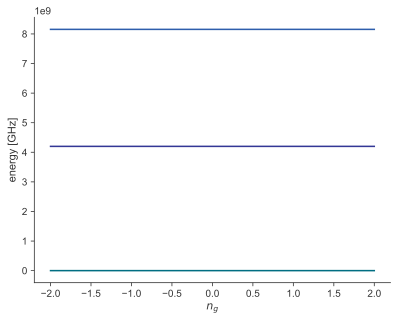

In [7]:
transmon.plot_evals_vs_paramvals('ng', ng_list, evals_count=3, subtract_ground=True)

In [8]:
cir = Network([
    C(0,1,c_sigma), # transmon
    J(0,1,'Lj'),
    C(0,2,c_r), # resonator
    L(0,2,l_r),
    C(1,2, c_qr), # coupling capacitor
    ])

f,k,A,chi = cir.f_k_A_chi(pretty_print=True, Lj = Lj)

         mode |       freq.  |       diss.  |       anha.  |
            0 |     4.32 GHz |          0Hz |      204 MHz |
            1 |     6.95 GHz |          0Hz |       306 Hz |

Kerr coefficients (diagonal = Kerr, off-diagonal = cross-Kerr)
         mode |         0    |         1    |
            0 |      204 MHz |              |
            1 |      500 kHz |       306 Hz |



In [9]:
clib = pd.read_csv("clockmon/clockmon_capacitance_library_sim_q3d_results.csv")

In [10]:
C11 = clib["C11"].values
C12 = clib["C12"].values
C13 = clib["C13"].values
C21 = clib["C21"].values
C22 = clib["C22"].values
C23 = clib["C23"].values
C31 = clib["C31"].values
C32 = clib["C32"].values
C33 = clib["C33"].values
coupler_widths_str = clib["coupler_extent"].values

coupler_widths = []
pattern = r'[-+]?\d*\.\d+|\d+'

for s in coupler_widths_str:
    match = re.search(pattern, s)
    if match:
        coupler_widths.append(float(match.group()))
    else:
        coupler_widths.append(None)

In [11]:
# Compute C_Sigma and C_qr
# Formulas adapted from https://qudev.phys.ethz.ch/static/content/science/Documents/semester/Burkhard_Simon_SemesterThesis_130211.pdf
c_sigma_lib = ((C33 + C13)*(C22 + C12))/(C33 + C22 + C13 + C12) + C23
beta = (C33*C12 - C22*C13)/((C33+C13)*(C22 + C12) + (C33 + C22 + C13 + C12)*C23)
c_qr_lib = beta*c_sigma

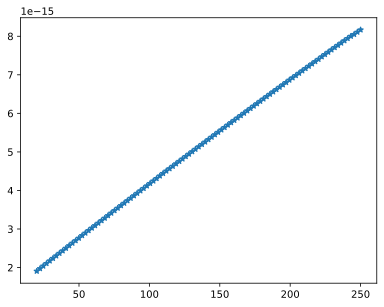

In [12]:
plt.plot(coupler_widths, c_qr_lib, '*')

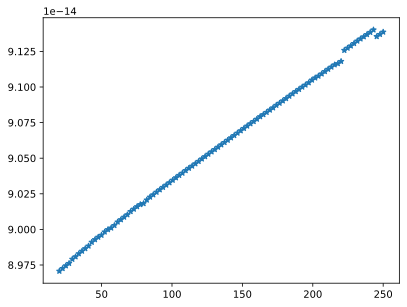

In [13]:
plt.plot(coupler_widths, c_sigma_lib, '*')

In [14]:
from scipy import interpolate
coupler_width_given_c_qr = interpolate.interp1d(c_qr_lib, coupler_widths)
c_sigma_given_coupler_width = interpolate.interp1d(coupler_widths, c_sigma_lib)

In [15]:
print("Coupler width:", coupler_width_given_c_qr(c_qr), "um")
print("Actual_C_Sigma: ", c_sigma_given_coupler_width(coupler_width_given_c_qr(c_qr)), "fF")

Coupler width: 113.20559551474852 um
Actual_C_Sigma:  9.04379374990858e-14 fF
